In [12]:
import os
import numpy as np
import sklearn.model_selection
import tensorflow as tf

from keras import Model
from keras.utils import image_dataset_from_directory, get_file
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import Flatten, Dense, Dropout

os.chdir("/tf/notebooks")   # Required to change dir in docker container to see local modules

from dataCleaning import load_and_preprocess_img

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.12.0
Num GPUs Available:  0


In [13]:
def init_vgg16():
    vgg16 = VGG16(weights=None,
                  include_top=False,
                  input_shape=(224, 224, 3))

    # Create a new 'top' of the model of fully-connected layers for Places365
    top_model = vgg16.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu', name="fc1")(top_model)
    top_model = Dropout(0.5, name="drop_fc1")(top_model)
    top_model = Dense(4096, activation='relu', name="fc2")(top_model)
    top_model = Dropout(0.2, name="drop_fc2")(top_model)
    output_layer = Dense(365, activation='softmax', name="predictions")(top_model)

    model = Model(inputs=vgg16.input,
                  outputs=output_layer,
                  name="vgg16-places365")

    WEIGHTS_PATH = 'https://github.com/GKalliatakis/Keras-VGG16-places365/releases/download/v1.0/vgg16-places365_weights_tf_dim_ordering_tf_kernels.h5'

    weights_path = get_file('vgg16-places365_weights_tf_dim_ordering_tf_kernels.h5',
                        WEIGHTS_PATH,
                        cache_subdir='models')

    model.load_weights(weights_path)

    return model

In [14]:
model = init_vgg16()

Model: "vgg16-places365"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)   

In [15]:
def preprocess_labelled_image(image: tf.Tensor, label) -> tuple:
    return tf.divide(image, 255), label


def load_data(filepath: str) -> tf.data.Dataset:
    dataset = image_dataset_from_directory(filepath,
                                        color_mode='rgb',
                                        image_size=(224,224))
    # dataset = dataset.map(preprocess_labelled_image)
    return dataset

data = load_data("/tf/notebooks/data/classification")

Found 9926 files belonging to 2 classes.


2023-05-01 09:59:32.659165: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [9926]
	 [[{{node Placeholder/_4}}]]
2023-05-01 09:59:32.659386: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [9926]
	 [[{{node Placeholder/_0}}]]


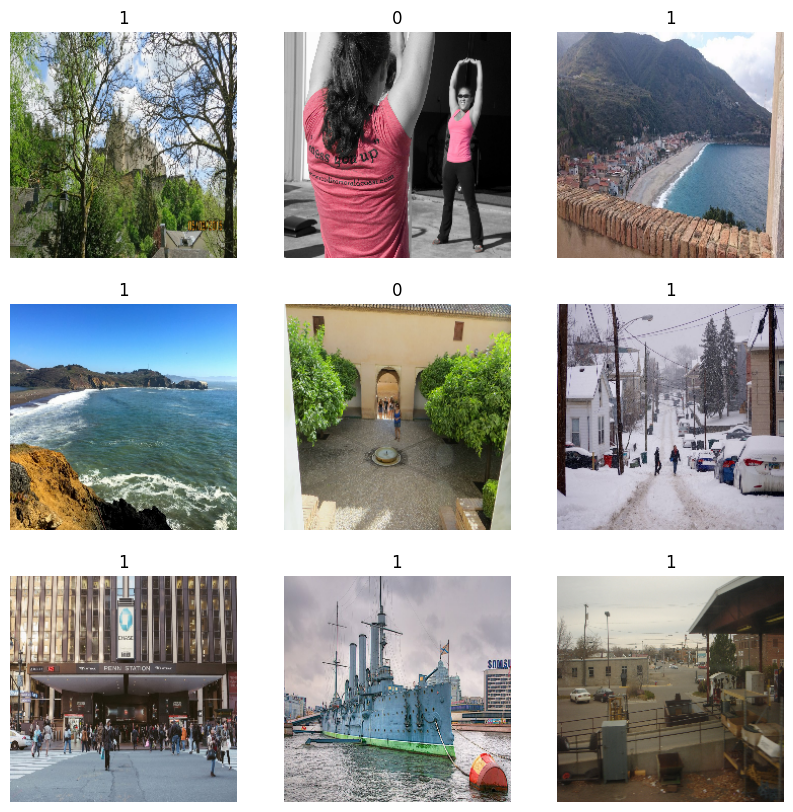

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(f"{labels[i]}")
    plt.axis("off")

In [ ]:
preds_file_path = "/tf/notebooks/classification_data.csv"
label_file_path = "/tf/notebooks/classification_labels.csv"

for images, labels in data:
    preds = model.predict(images)
    with open(preds_file_path, 'ab') as file:
        np.savetxt(file, preds, delimiter=',')

    with open(label_file_path, 'ab') as file:
        int_labels = labels.numpy().astype("uint8")
        np.savetxt(file, int_labels, delimiter=',', fmt='%i')

2023-05-01 09:59:50.791738: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [9926]
	 [[{{node Placeholder/_4}}]]
2023-05-01 09:59:50.792081: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [9926]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 2s 2s/step


In [ ]:
import pandas as pd
import sklearn
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

X = pd.read_csv(preds_file_path)
y = pd.read_csv(label_file_path).squeeze()

print("X: ", X.shape)
print("y: ", y.shape)

print("pos: ", y[y==1].count())
print("neg: ", y[y==0].count())
print("Classify all pos = ", y[y==1].count()/y.count())

assert len(X) == len(y)

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
accs = []

for n in range(100, 500, 50):
    print(f"clf: {n}")
    clf = RandomForestClassifier(n_estimators=n,
                                 random_state=42,
                                 n_jobs=-1)
    clf.fit(X_train, y_train)
    y_preds = clf.predict(X_test)
    accs.append(accuracy_score(y_test, y_preds))

plt.plot(accs)

In [ ]:
accs = []

for n in range(100, 550, 50):
    print(f"clf: {n}")
    clf = AdaBoostClassifier(n_estimators=n,
                            random_state=42)
    clf.fit(X_train, y_train)
    y_preds = clf.predict(X_test)
    accs.append(accuracy_score(y_test, y_preds))

plt.plot(accs)